In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from Tensor import Tensor

# Convolutions
## Inductive Bias:

归纳偏置在机器学习中是一种很微妙的概念：在机器学习中，很多学习算法经常会对学习的问题做一些假设，这些假设就称为归纳偏置(Inductive Bias)。归纳偏置这个译名可能不能很好地帮助理解，不妨拆解开来看：归纳(Induction)是自然科学中常用的两大方法之一(归纳与演绎, induction and deduction)，指的是从一些例子中寻找共性、泛化，形成一个比较通用的规则的过程；偏置(Bias)是指我们对模型的偏好。因此，归纳偏置可以理解为，从现实生活中观察到的现象中归纳出一定的规则(heuristics)，然后对模型做一定的约束，从而可以起到“模型选择”的作用，即从假设空间中选择出更符合现实规则的模型。其实，贝叶斯学习中的“先验(Prior)”这个叫法，可能比“归纳偏置”更直观一些。归纳偏置在机器学习中几乎无处不可见。老生常谈的“奥卡姆剃刀”原理，即希望学习到的模型复杂度更低，就是一种归纳偏置。另外，还可以看见一些更强的一些假设：KNN中假设特征空间中相邻的样本倾向于属于同一类；SVM中假设好的分类器应该最大化类别边界距离；等等。在深度学习方面也是一样。以神经网络为例，各式各样的网络结构/组件/机制往往就来源于归纳偏置。在卷积神经网络中，我们假设特征具有局部性(Locality)的特性，即当我们把相邻的一些特征放在一起，会更容易得到“解”；在循环神经网络中，我们假设每一时刻的计算依赖于历史计算结果；还有注意力机制，也是基于从人的直觉、生活经验归纳得到的规则。在自然语言处理领域赫赫有名的word2vec，以及一些基于共现窗口的词嵌入方法，都是基于分布式假设：A word’s meaning is given by the words that frequently appear close-by. 这当然也可以看作是一种归纳偏置；一些自然语言理解的模型中加入解析树，也可以类似地理解。都是为了选择“更好”的模型。


In convolution NN, the model considers the spatial equivariance nature of the images. In other words, the input image is shifted by some offset, the output will be shifted in the same manner. This indcution is "hardcoded" in the convolution model.

## Implementation of CNN
The functions below are integrated in the Tensor class

__getitem__() is a magic method in Python, which when used in a class, allows its instances to use the [] (indexer) operators.

In [ ]:
def __getitem__(self, idx):
    out_data = np.ray(self.data[idx])
    # here out_data shall be a numpy array
    out = Tensor(
                data=out_data, children=(self,),
                requires_grad=self._requires_grad, label="get_item"
                )

    # this is a getitem operation
    # so it could also has backward, we can directly pass the gradient to
    # its children self.data[idx]
    def _backward(self):
        self.grad[idx] += out.grad

    out._backward = _backward
    return out

# test case:
A = Tensor(np.array([1, 2, 3, 4, 5]), requires_grad=True)
A[1:]

Tensor(data=[2 3 4 5])

In [ ]:
# padding: extend the image by some number of pixels

def pad2d(self, padding:int):
    """
    pad the last two dimensions with 0s
    """

    # make sure the padding is positive
    # make sure the data is at least 2d
    assert padding > 0
    assert len(self.data.shape) >= 2

    # compute the shape of the output data
    out_shape = list(self.data.shape)
    for i in [-1, -2]:
        out_shape[i] += 2 * padding

    # initialize output data
    out_data = np.zeros(out_shape)

    # update output data by the input: the sides will be 0, center will be
    # input data
    out_data[:, padding:-padding, padding:-padding] = self.data

    # construct the tensor
    out = Tensor(
                data=out_data, children=(self,),
                requires_grad=self._requires_grad,
                operations = "pad_2d"
                )

    # backward function
    def _backward():
        self.grad += out.grad[:, padding:-padding, padding:-padding]

    out._backward = backward

    return out


## Kernel loop

Instead of looping over the pixels, the model deal with convolution in a more
efficient way: loop over the kernels (2k+1)*(2k+1) where k is the single side
length of the kernel


> Kernel is a Tensor as well

> Four boundaries of the inputs will only be multiplied by a few entries of the kernel

> Convolution with no padding leads to shrinkage of dimension H and W, to keep
the input and output size the same, one must add k padding.

In [4]:
A = np.array([1, 2, 3, 4])
B = np.array([[2, 5, 7, 9], [1, 3, 4, 6]])
B += A

B

array([[ 3,  7, 10, 13],
       [ 2,  5,  7, 10]])

In [5]:
def conv2d(self, kernel, padding=None):
    kernel_size = list(kernel.data.shape)[-1]
    if padding==None:
        padding = kernel_size // 2

    # pad the input
    input_data = self.pad2d(padding=padding)

    # initialize the output
    out = Tensor(
                data = np.zeros_like(self.data), children=(self, kernel),
                label = "conv2d", requires_grad=True
                )

    # the shape of self
    h, w = self.data.shape[-2:]

    for i in range(k):
        for j in range(k):
            # for each (i,j), we take only a part of the input_data
            # the shape of the taken part is out.data.shape
            out.data += input_data[i:h+i, j:h+j] * kernel(i,j)

    return out


### Test the kernel by a smooth kernel

/tmp/ipykernel_3136/1170428992.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  lena = imageio.imread(url)


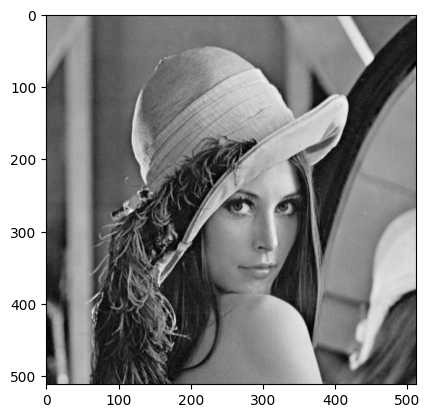

In [6]:
# Test image for 2D convolution
import imageio
url = 'https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png'
lena = imageio.imread(url)

plt.imshow(lena)

from PIL import Image

# make gray-scale image
lena_bw = Image.fromarray(lena).convert('L')
plt.imshow(lena_bw, cmap='gray')

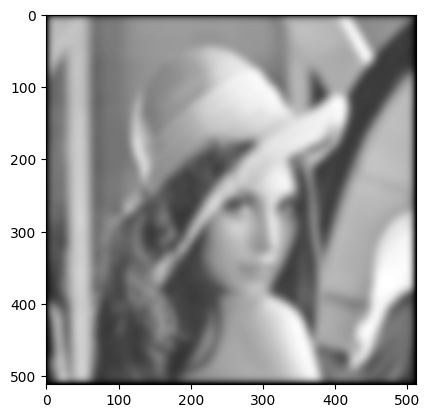

In [21]:
# wrap the image as a tensor
lena_bw_array = np.array(lena_bw) / 255.0
lena_bw_smooth = Tensor(data = lena_bw_array)

smooth_kernel = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])/9.0
smooth_kernel = Tensor(data=smooth_kernel)

for i in range(54):
    lena_bw_smooth = lena_bw_smooth.conv2d(kernel=smooth_kernel)

plt.imshow(lena_bw_smooth.data, cmap='gray')
plt.show()

multichannel

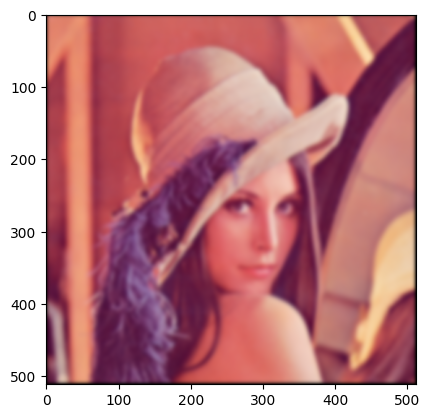

In [31]:
lena_normalized = (lena.astype(np.float32) / 255.0).transpose(2, 0, 1)
lena_tensor = Tensor(data=lena_normalized)
smooth_kernel = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])/9.0
empty_kernel = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]])

smooth_kernel1 = Tensor(data=[smooth_kernel, empty_kernel, empty_kernel])
smooth_kernel2 = Tensor(data=[empty_kernel, smooth_kernel, empty_kernel])
smooth_kernel3 = Tensor(data=[empty_kernel, empty_kernel, smooth_kernel])

lena_smooth = lena_tensor
for i in range(13):
    # the output for the conv2d is a one channel image
    lena_smooth1 = lena_smooth.conv2d(kernel=smooth_kernel1)
    lena_smooth2 = lena_smooth.conv2d(kernel=smooth_kernel2)
    lena_smooth3 = lena_smooth.conv2d(kernel=smooth_kernel3)

    lena_smooth = np.stack([lena_smooth1.data, lena_smooth2.data, lena_smooth3.data], axis=0)
    lena_smooth = Tensor(data=lena_smooth)
plt.imshow(lena_smooth.data.transpose(1, 2, 0))

MIMO channel convolution

Kernel size: $c_{in} \times c_{out} \times (2k+1)^2$

identity filter:

000

010

000

[[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]]


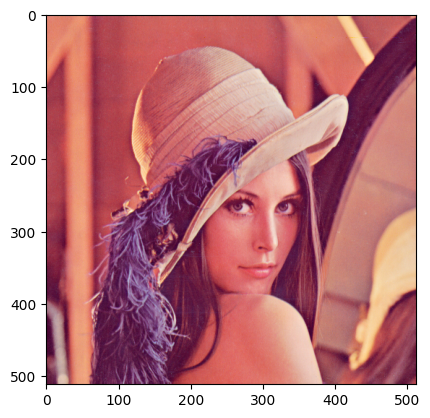

In [14]:
# identity kernel with dimension c_in x c_out x 3 x 3

identity_kernel = np.zeros((3, 3, 3, 3))
for i in range(3):
        # if the in channel and out channel is not the same -> filter is 0
        identity_kernel[i, i, 1, 1] = 1

print(identity_kernel[0,0])
identity_kernel = Tensor(data = identity_kernel)

lena_normalized = lena/255.0
lena_normalized = lena_normalized.transpose(2, 0, 1)

lena_identity = Tensor(data=lena_normalized)

lena_identity = lena_identity.conv2d(identity_kernel)

plt.imshow(lena_identity.data.transpose(1, 2, 0), cmap='gray')

# Pooling
One of the option to downsample and reduce dimension
Another is to change the **stride** 

Theoretically we can set stride for pooling operations as well.
Here we have stride = kernel_size

backward function for max pooling:

1 for max values and 0 for the others:

Only when the max changes, the max pooled tensor will change.

Or think about $$\partial{||_\infinite}$$

In [35]:
def max_pool(self, kernel_size: int = 2):
    input_data = self.data
    input_shape = self.data.shape
    assert input_shape[-2] % kernel_size == 0
    assert input_shape[-1] % kernel_size == 0

    nx = input_shape[-2] // kernel_size
    ny = input_shape[-1] // kernel_size

    input_reshape = (-1, ny, kernel_size, nx, kernel_size)
    input_data = input_data.reshape(input_reshape)

    out_data = np.max(input_data, axis = (-1, -3))

    return Tensor(out_data, children=(self, ), operation = "max-pool")


# test case
A = np.array([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12], [13, 14, 15, 16]])
print(A)
A = Tensor(data=A)
print(max_pool(A, kernel_size=2).data)

[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]]
[[[ 6  8]
  [14 16]]]


## Flatten
Tensor to a 1D vector

In [36]:
def flatten(self):
    out_data = self.data.flatten()
    out_data = Tensor(data=out_data, children=(self,), operation="flatten")

    def _backward():
        # just reshape the gradient to the shape of self.data
        self.grad == out_data.grad.reshape(self.data.shape)

    out_data._backward = _backward

    return out_data

# CNN

In [ ]:
class CNN:
    def __init__(self, hidden_dims, kernel_size, n_out):
        self.kernels = []
        for i in range(len(hidden_dims - 1)):
            kernel = np.random.uniform(low = -0.05, high = 0.05, size=(
                hidden_dims[i], hidden_dims[i+1], kernel_size[i], kernel_size[i]
            ))
            self.kernels.append(kernel)

        linear = np.random.uniform(low = -0.05, high = 0.05, size=(
            n_out, 7*7*hidden_dims[-1]
        ))

    def __call__(self, x):

        for kernel in self.kernels:
            x = x.conv2d(kernel)
            x = x.relu()
            x = x.max_pool(2, 2)


        x.flatten
        x = self.linear @ x
        x = x.softmax()
        return x

    def parameters(self):

        params = [self.linear]
        for kernel in self.kernels:
            params.append(kernel)
        return params